# MNIST 手寫數字辨識資料集 使用多層感知器模型(MLP)

# Step1. 匯入keras 與相關套件
首先匯入kares及相關的套件 :

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import numpy as np
import pandas 
from keras.utils import np_utils #用來將label資料轉換成 one-hot-encoding

from sklearn.utils import shuffle
from tqdm import tqdm

C:\Users\emprise\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''設定參數'''
batch_size =32
epochs = 100
lr = 0.001

# Step2. 下載mnist資料
下載MNIST資料並讀取


In [3]:
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

print("[info] train data = {:,}".format(len(X_train_image)))
print("[info] test data = {:,}".format(len(X_test_image)))

[info] train data = 60,000
[info] test data = 10,000


In [4]:
X_train_image.shape

(60000, 28, 28)

由上得知training data 共有60,000筆; testing data 共有10,000筆

# 查看訓練資料
接著我們來看載入資料的長相與格式

# 訓練資料是由images 與 label組成

In [5]:
print("[info] shape of train data=%s" % str(X_train_image.shape))
print("[info] shape of train label=%s" % str(y_train_label.shape))

[info] shape of train data=(60000, 28, 28)
[info] shape of train label=(60000,)


訓練資料是由60000筆image所組成，每一筆代表數字的影像是 28x28 pixels.


# 資料前處理
1.先將images以reshape轉換為二維ndarray，並進行normalization(Feature scaling)。

2.labels進行one-hot encoding。

In [7]:
# Reshape
x_Train = X_train_image.reshape(60000, 28*28).astype('float32')
x_Test = X_test_image.reshape(10000, 28*28).astype('float32')

# Normalization
x_train = x_Train/255
x_test = x_Test/255

# labels to one-hot encoding
y_train = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_test = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding


# 將Training data切分出Validation sets
資料原本已經切分為train 與test的部分，所以我們在將training data切分出validation data作為驗證。

In [8]:
#資料training set, validation set 分割
x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size = 0.1,
                                                      stratify = y_train.argmax(axis = 1))
print("[info] training set data dimension")
print("[info] ", x_train.shape)
print("[info] ", y_train.shape)
print("-----------")
print("[info] training set: %i" % len(x_train))
print("[info] validation set: %i" % len(x_valid))
print("[info] testing set: %i" % len(x_test))

[info] training set data dimension
[info]  (54000, 784)
[info]  (54000, 10)
-----------
[info] training set: 54000
[info] validation set: 6000
[info] testing set: 10000


# Model

In [9]:
# ------------------------------------graph-----------------------------------------
tf.reset_default_graph() # clean graph
# Declare the input node
with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None,x_train.shape[1]), 
                             name = 'x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape = (None, y_train.shape[1]), 
                           name = 'y_label',
                           dtype=tf.float32)

# --------------------Declare the network structure----------------------------
#hidden layer設定為三層分別從784-256-128-64-10 
with tf.variable_scope('hidden_layer1'):
    x_h1 = tf.layers.dense(inputs= x_input, units= 256, activation=tf.nn.relu)
    
with tf.variable_scope('hidden_layer2'):
    x_h2 = tf.layers.dense(inputs= x_h1, units= 128, activation=tf.nn.relu)
    
with tf.variable_scope('hidden_layer3'):
    x_h3 = tf.layers.dense(inputs= x_h2, units= 64, activation=tf.nn.relu)


with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h3, 10)

with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_out))
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(y_out,1)) #如果答案對則回傳truth
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #將回傳的truth/false轉乘1/0並計算平均(計算正確率)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

100%|██████████| 100/100 [12:09<00:00,  7.30s/it]


--- training done ---
testing accuracy: 0.98


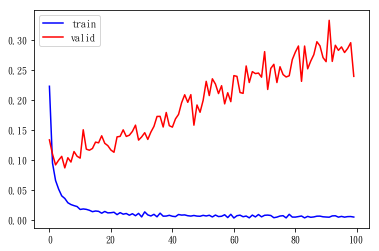

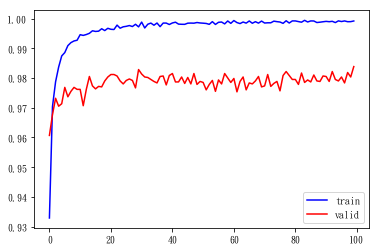

In [10]:
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
#--------------------------------------sess--------------------------------------------
#用類似open file的方式開啟sess(就不用再自己關閉session了)
with tf.Session() as sess:
    # we have to initalize all variables (e.g. weights/biases) at the begin
    sess.run([tf.global_variables_initializer()])
    
    for i in tqdm(range(epochs)):
        # get batch 
        total_batch = int(np.floor(len(x_train) / batch_size)) #返回小於等於 該數值的最大整數
        # 透過batch size 與資料量計算有幾個batch
        train_loss_collector, train_acc_collector = [], []
        for j in np.arange(total_batch):
            batch_idx_start = j * batch_size
            batch_idx_stop = (j+1) * batch_size

            x_batch = x_train[batch_idx_start : batch_idx_stop]
            y_batch = y_train[batch_idx_start : batch_idx_stop]
            
            this_loss, this_acc, _ = sess.run([loss, compute_acc,train_step],
                                    feed_dict = {x_input: x_batch,
                                                 y_out: y_batch})
            #定義train , acc 的collector list 接收
            train_loss_collector.append(this_loss)
            train_acc_collector.append(this_acc)
            
        # do validation at the end of each epoch
        valid_acc, valid_loss = sess.run([compute_acc, loss],
                                         feed_dict = {x_input: x_valid,
                                                      y_out : y_valid})
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        
        train_loss_list.append(np.mean(train_loss_collector))
        train_acc_list.append(np.mean(train_acc_collector))

        # at the end of each epoch, shuffle the data
        x_train, y_train = shuffle(x_train, y_train)
    # At the end of the training, do testing set
    test_acc, test_loss = sess.run([compute_acc, loss],
                                    feed_dict = {x_input: x_test,
                                                 y_out : y_test})
print('--- training done ---')
print('[info] testing accuracy: %.2f' % test_acc)
#--------------------------------------plot---------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.show()

  - 第一張圖的valid_loss(r)不斷的偏高，但test後的準確度還是有達到0.98

  - valid_loss的性能待測試。